### Group Members:

- Daniel Gergely, 19-492-750

# Zero Shot Learning and Auto-Labelling Pipeline

## CLIP Zero-shot Classification

In the first part of the assignment, we will be doing zero-shot classification -- i.e. classifying images into classes without training on them -- using the CLIP model on the intel-image dataset containing the following classes: buildings, forests, glaciers, mountains, seas, and streets.

### Note for Windows Users:

Several parts of the code use the Linux command `wget` to download files.
You need to replace these by `curl` instructions.

### Dataset

For this exercise we use the  [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) dataset that can be downloaded from the official website [here]({https://www.kaggle.com/datasets/puneet6060/intel-image-classification}).
The dataset contains $25000$ color images of pixels size $150\times 150$ in $6$ classes: buildings, forests, glaciers, mountains, seas, and streets.
Here, we will use only the test set which contains $3000$ images.

### Download the dataset by running the code below

In [ ]:
# Library for downloading datasets from Kaggle
! pip install opendatasets --upgrade --quiet
# Library including Huggingface Transformer models
! pip install transformers

In [ ]:
import os
import json

# Write the kaggle.json file
with open('kaggle.json', 'w') as file:
    json.dump({'username': '', 'key': ''}, file)

import opendatasets as od
od.download('https://www.kaggle.com/puneet6060/intel-image-classification')

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


### Task 1: Data Transformation

Since we will be using the pre-trained VIT model for image embedding, we need to apply the following transforms on our data:

1. We need to resize the image to $224\times224$.
2. We need to convert the image into a tensor (including pixel values scaling).
3. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)$.

In [ ]:
import torch
import torchvision

imagenet_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Task 2: Dataset Loading and Transforms

We here use the [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) class from pytorch to load our training and test set respectively.

This task consists of two parts:

1. Create one dataset for the test set. Use the transform defined above.
2. Create a dataloader with a batch size of 32 for the test set.

In [ ]:
# To create datasets from folders
from torchvision.datasets import ImageFolder

# Path to your test data
test_dir = './intel-image-classification/seg_test/seg_test/'
# Use ImageFolder function to create your dataset as done in Assignment 7
dataset_test = ImageFolder(root=test_dir, transform=imagenet_transform)

# Instantiate data loader
batch_size = 32
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

### Test 1: Data Size and Types

We check that all input images are `torch.tensors` of size $3\times224\times224$ and of type `torch.float` and that all labels are of type `int`.

Note: the sanity check is only performed on the test set.

In [ ]:
for x, t in dataset_test:
    assert isinstance(x, torch.Tensor)
    assert isinstance(t, int)
    assert x.dtype==torch.float
    assert x.shape==(3,224,224)
    assert x.max() < 3.0
    assert x.min() > -3.0

### Task 3: Create Text Prompts for CLIP Model.

For each class in your dataset, you need to create a text prompt.
You can make different prompts for different classes that might help improve the model performance.
Here is an easy example: `"This is an image of {class}"`.
Keep in mind the index of your list should be related to the class for which you are writing the prompt.

For reference:

1. index 0 - Buildings
2. index 1 - Forest
3. index 2 - Glacier
4. index 3 - Mountain
5. index 4 - Sea
6. index 5 - Street

In [ ]:
# Write one text prompt for each of the 6 classes above
text_prompts = [
    "This is an image of a building",
    "This is an image of a forest",
    "This is an image of a glacier",
    "This is an image of a mountain",
    "This is an image of a sea",
    "This is an image of a street"
]

### Task 4: Initialize CLIP Model and Encode your Text Prompts

The text prompts need to be embedded by the CLIP model. This is what we do here.

1. Example of initialization can be found here: https://huggingface.co/docs/transformers/en/model_doc/clip
2. Documentation of CLIPProcessor: https://huggingface.co/docs/transformers/v4.41.1/en/model_doc/clip#transformers.CLIPProcessor
3. Documentation of CLIPModel: https://huggingface.co/docs/transformers/v4.41.1/en/model_doc/clip#transformers.CLIPModel
4. Documentation for other methods of CLIP: https://huggingface.co/transformers/v4.8.0/model_doc/clip.html

In [ ]:
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Set your device here
#device = torch.device("mps")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Initializing the processor and CLIP model.
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [ ]:
# Create your label tokens - This will contain your input_ids of the tokens and the attention masks.
label_tokens = processor(
    text=text_prompts, # Set it to your text prompt list
    padding=True, # Set it to True in case the text prompts are of different lengths
    images=None, # Since here we are only interested in textual embeddings for the labels
    return_tensors='pt' # Get PyTorch tensors
).to(device)

To get the embeddings, call the model with the method `get_text_features`.
Reference: https://huggingface.co/transformers/v4.8.0/_modules/transformers/models/clip/modeling_clip.html#CLIPModel.get_text_features

In [ ]:
# Encode your label tokens to get text embeddings of shape (n_labels, 512)
label_emb = model.get_text_features(input_ids=label_tokens.input_ids, attention_mask=label_tokens.attention_mask).to(device)

# Detach your "label_emb" from gpu (if it was on it)
label_emb = label_emb.detach().cpu()

# Normalize your embeddings by dividing by the norm (make sure you use the right axis)
label_emb = label_emb / label_emb.norm(dim=-1, keepdim=True)

### Task 5: Get Image Embeddings and Estimate the Labels

To classify the images via CLIP, you need to do the following steps:

1. Get image embeddings using `get_image_features` function (the only input argument will be your image tensors). Reference: https://huggingface.co/transformers/v4.8.0/model_doc/clip.html#transformers.FlaxCLIPModel.get_image_features
2. Calculate the dot product between your image embeddings and your label embeddings.
3. The label with the highest similarity will be the predicted class.

In [ ]:
# To store the predicted labels and the true labels
y_pred = []
y_true = []

# Loop through your testloader here

for imgs, labels in testloader:
    # Put your imgs to device, No need to put the labels to device
    imgs = imgs.to(device)

    # Extend your list "y_true" with the labels. Make sure to detach and convert to cpu
    y_true.extend(labels.detach().cpu().numpy().tolist())

    # Get image embeddings of your batch
    img_embd = model.get_image_features(imgs)

    # Detach your img_embd from gpu. Your img_embd shape should be (batch_size, 512)
    img_embd = img_embd.detach().cpu()

    # Calculate the scores between img_embd and label_emb
    scores = torch.matmul(img_embd, label_emb.T)

    # Get your final prediction by taking the argmax of the scores (Make sure you use the correct axis here)
    pred = scores.argmax(dim=1)

    # Extend your "y_pred" list with pred
    y_pred.extend(pred.tolist())

### Task 6: Evaluation and Comparison

Calculate the confusion matrix from the predicted and true labels.
Plot the confusion matrix and compare it to the results of Assignment 7 (ResNet50 with frozen layers).
The confusion matrix has been provided below from the Assignment 7.

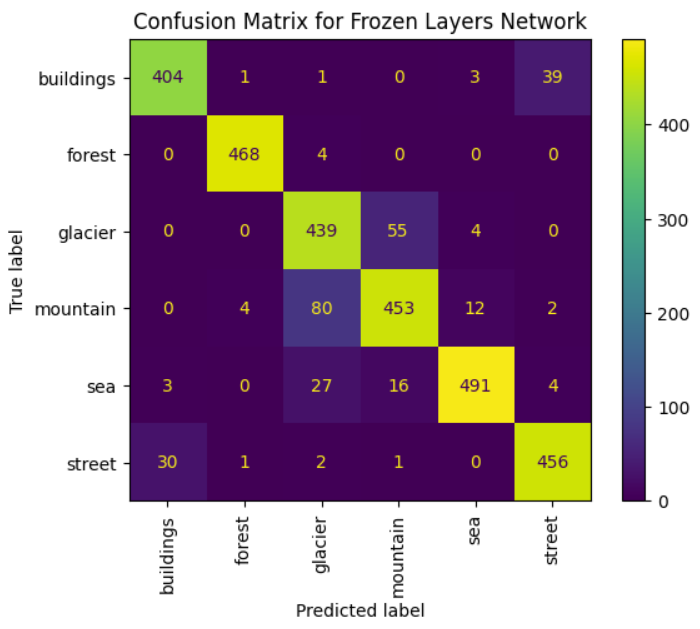

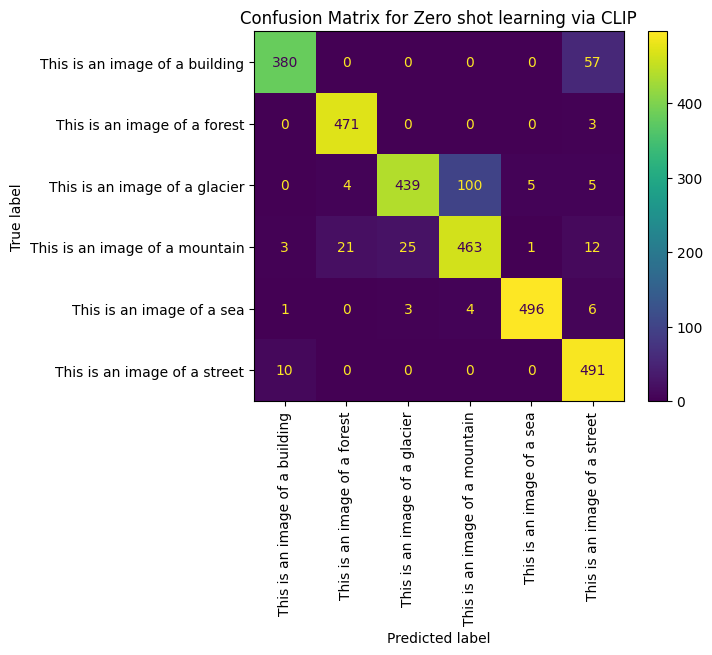

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix from predictions and true labels
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=text_prompts)
plot_conf_matrix.plot(xticks_rotation = "vertical")
plt.title('Confusion Matrix for Zero shot learning via CLIP')
plt.show()

### Comment on the questions below:
- Does CLIP perform worse or better than a pre-trained ResNet50?
  - Looking at the two confusion matrices, there seems to be no significant difference between the two approaches.
- Can fine-tuning the model make it even better?
   - Fine-tuning the model can make it better as it can learn the specific features of the dataset.
- What are the advantages of CLIP?
    - CLIP can be used for zero-shot learning, which means it can be used to classify images without needing to label data.

## Automatic Image labeling (Tagging, Detection and Segmentation)

In the second part of this assignment, we will be using various pre-trained models to automatically annotate images (create tags, bounding boxes and segmentation masks).
For this purpose, we will be using three different models:

1. RAM - Recognize Anything Model (Image caption generation)
2. GroundingDINO model (Zero-shot detection)
3. SAM - Segment Anything Model (Segmentation)

For this exercise, we will run the pipeline for only a handful of images taken from University of Oxford VGG group.

### Download the Dataset

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/iseg/data/images.tgz
!tar -xvf images.tgz

--2024-05-27 10:16:16--  https://www.robots.ox.ac.uk/~vgg/data/iseg/data/images.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/iseg/images.tgz [following]
--2024-05-27 10:16:16--  https://thor.robots.ox.ac.uk/datasets/iseg/images.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23030716 (22M) [application/octet-stream]
Saving to: ‘images.tgz.2’

images.tgz.2        100%[===================>]  21.96M  16.0MB/s    in 1.4s    

2024-05-27 10:16:18 (16.0 MB/s) - ‘images.tgz.2’ saved [23030716/23030716]

images/
images/person_2008_001375.jpg
images/person_2008_000584.jpg
images/person_2008_000510.jpg
images

In [ ]:
# We will only be using the following images; you might change this if you want
images_path = ["images/sheep_2007_003593.jpg", "images/208001.jpg", "images/106024.jpg", "images/aero_2007_001884.jpg", "images/bike_2007_005878.jpg", "images/cat_2007_007530.jpg"]

### Install the Necessary Libraries and Download the Weights of the three Models

In [ ]:
# Install the packages
!pip install groundingdino-py
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/xinyu1205/recognize-anything.git

# Download weights of each model
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha2/groundingdino_swinb_cogcoor.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth

# Download the configuration file
!wget https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinB_cfg.py

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6zdo2036
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6zdo2036
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/xinyu1205/recognize-anything.git to /tmp/pip-req-build-gegfegfn
  Running command git clone --filter=blob:none --quiet https://github.com/xinyu1205/recognize-anything.git /tmp/pip-req-build-gegfegfn
  Resolved https://github.com/xinyu1205/recognize-anything.git to commit a6a8bfa84e9868bbb91b436cf1c02a6cb6fee27d
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-82daap6w/clip_71a9490ce04f4eae8dbfbfc548a6bd6e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-

In [ ]:
# Import the libraries
from groundingdino.models import build_model
import groundingdino.datasets.transforms as T
from groundingdino.util.inference import annotate, load_image, predict
from huggingface_hub import hf_hub_download
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from segment_anything import build_sam, SamPredictor
import torch
from ram import get_transform, inference_ram
from ram.models import  ram
from PIL import Image
import numpy as np
from itertools import chain
import torchvision
import cv2

### Task 7: Initialize the three models

Run the cells below to initialize the three models. No particular code needs to be added from your side.

In [ ]:
# Set your device here
#device = torch.device("mps")
device = torch.device("cuda")

# Initialize your caption model here (RAM - Recognize Anything Model)
model_caption = ram(pretrained="ram_swin_large_14m.pth",
                    image_size=384,
                    vit="swin_l")

# Put the model in eval mode and move it to device
model_caption.eval().to(device)

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
ram_swin_large_14m.pth
--------------
load checkpoint from ram_swin_large_14m.pth
vit: swin_l


RAM(
  (visual_encoder): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=192, input_resolution=(96, 96), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=192, input_resolution=(96, 96), num_heads=6, window_size=12, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=192, window_size=(12, 12), num_heads=6
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-

In [ ]:
# Initialize SAM
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

In [ ]:
# Helper functions
def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

# Visualization
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    ax.text(x0, y0, label)


# GroundingDINO bbox cleaning
def get_grounding_output(model, image, caption, box_threshold, text_threshold,device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    scores = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        scores.append(logit.max().item())

    return boxes_filt, torch.Tensor(scores), pred_phrases

### Task 8: Run the pipeline to create the labels, bbox and segmented masks

In [43]:
# BBOX configuration
bbox_threshold = 0.3
text_threshold = 0.25
iou_threshold = 0.4

#Loop through the images_path
for image_path in images_path:
    # Step 1: Get the pil image and the image tensor using the "load_image" function defined above
    image_pil, image = load_image(image_path)

    # Step 2: Get Tags using the RAM model
    transform = get_transform(image_size=384) # RAM model transforms

    # It takes image_pil as input. You need to add a dummy dimension at the first index for the batch dimension and move the image to device
    raw_image  = transform(image_pil).unsqueeze(0).to(device)

    # This gives the tags (English at index 0 and Chinese at index 1)
    res = inference_ram(raw_image, model_caption)

    # Access the english tags and replace "|" with ","
    tags = res[0].replace("|", ", ")

    # Step 3: Run GroundingDINO model

    # Get GroundingDINO outputs
    boxes_filt, scores, pred_phrases = get_grounding_output(
        model_dino, image, tags, bbox_threshold, text_threshold, device=device
    )

    # adapt the returned bounding boxes to the image shape
    size = image_pil.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]
    boxes_filt = boxes_filt.cpu()

    # use NMS to handle overlapping boxes
    print(f"Before NMS: {boxes_filt.shape[0]} boxes")
    nms_idx = torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
    boxes_filt = boxes_filt[nms_idx]
    pred_phrases = [pred_phrases[idx] for idx in nms_idx]
    print(f"After NMS: {boxes_filt.shape[0]} boxes")

    # SAM only works with numpy arrays, not with PIL
    image_sam = np.array(image_pil)
    sam_predictor.set_image(image_sam)

    # Apply the detected bounding boxes
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_filt, image_sam.shape[:2]).to(device)

    # extract the segmentation masks from the SAM model
    masks, _, _ = sam_predictor.predict_torch(
        point_coords = None,
        point_labels = None,
        boxes = transformed_boxes,
        multimask_output = False,
    )

    # draw output image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_sam)

    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)

    for box, label in zip(boxes_filt, pred_phrases):
        show_box(box.numpy(), plt.gca(), label)

NameError: name 'model_dino' is not defined